In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots;

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [4]:
# Parameters
grid_resolution        = 100
quadrature_order       = 2
ϵ                      = 0.01             # perturbation
selected_ev            = 2
t_initial              = minimum(Time)
t_end                  = t_initial+80     # parameter value corresponding to ϵ=0 (t_max is 90)
wind_scale             = 1e-5
wind_center            = 30;
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5()

BS5(true)

In [5]:
lattitude_range = range(minimum(Lat),maximum(Lat),length=size(UT)[2]) # should be equal to Lat, but just to be safe
wind_u = repeat(collect(wind_scale.*(lattitude_range.-wind_center))',size(UT)[1],1,size(UT)[3])
wind_v = zero(VT); #no northward component of wind
wind = interpolateVF(Lon, Lat, Time, wind_u, wind_v);

In [6]:
# it would be much easier to write this with interp_rhs and p=UV .+ param.*wind, but that has the wrong type
interp_rhs_scaled = OrdinaryDiffEq.ODEFunction{false}((u,p,t) -> p[1](u[1],u[2],t) .+ p[3].*p[2](u[1],u[2],t))
function T(x,param)
    flow(interp_rhs_scaled, x, [t_initial, t_end]; 
        p=(UV, wind, param), tolerance=solver_tolerance, solver=solver)[end]
end

T (generic function with 1 method)

In [7]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [8]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [9]:
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

 33.838016 seconds (56.29 M allocations: 3.056 GiB, 2.56% gc time)


In [10]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀[:,selected_ev])
λ₀ = real.(λ₀[selected_ev])
u₀ = u₀ ./ sqrt(u₀'*M*u₀)        # L2 normalization
if u₀[Int(floor(0.75*lat_resolution*lon_resolution+0.75*lon_resolution))]<0
    u₀ = -u₀
end
λ₀

  2.954225 seconds (9.38 M allocations: 519.490 MiB, 3.66% gc time)


-19.992545588673103

In [11]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata);

201.240116 seconds (1.49 G allocations: 179.476 GiB, 11.07% gc time)


In [12]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀    ;  0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  0.615385 seconds (2.38 M allocations: 125.637 MiB, 3.42% gc time)


11.856450298803097

In [13]:
# calculate the exact uϵ
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ[:,selected_ev])
λϵ = real.(λϵ[selected_ev])
uϵ = uϵ ./ sqrt(uϵ'*M*uϵ)
if uϵ[Int(floor(0.75*lat_resolution*lon_resolution+0.75*lon_resolution))]<0
    uϵ = -uϵ
end
λϵ

-19.990575388793935

In [14]:
λ₀ + ϵ*λ_dot 

-19.87398108568507

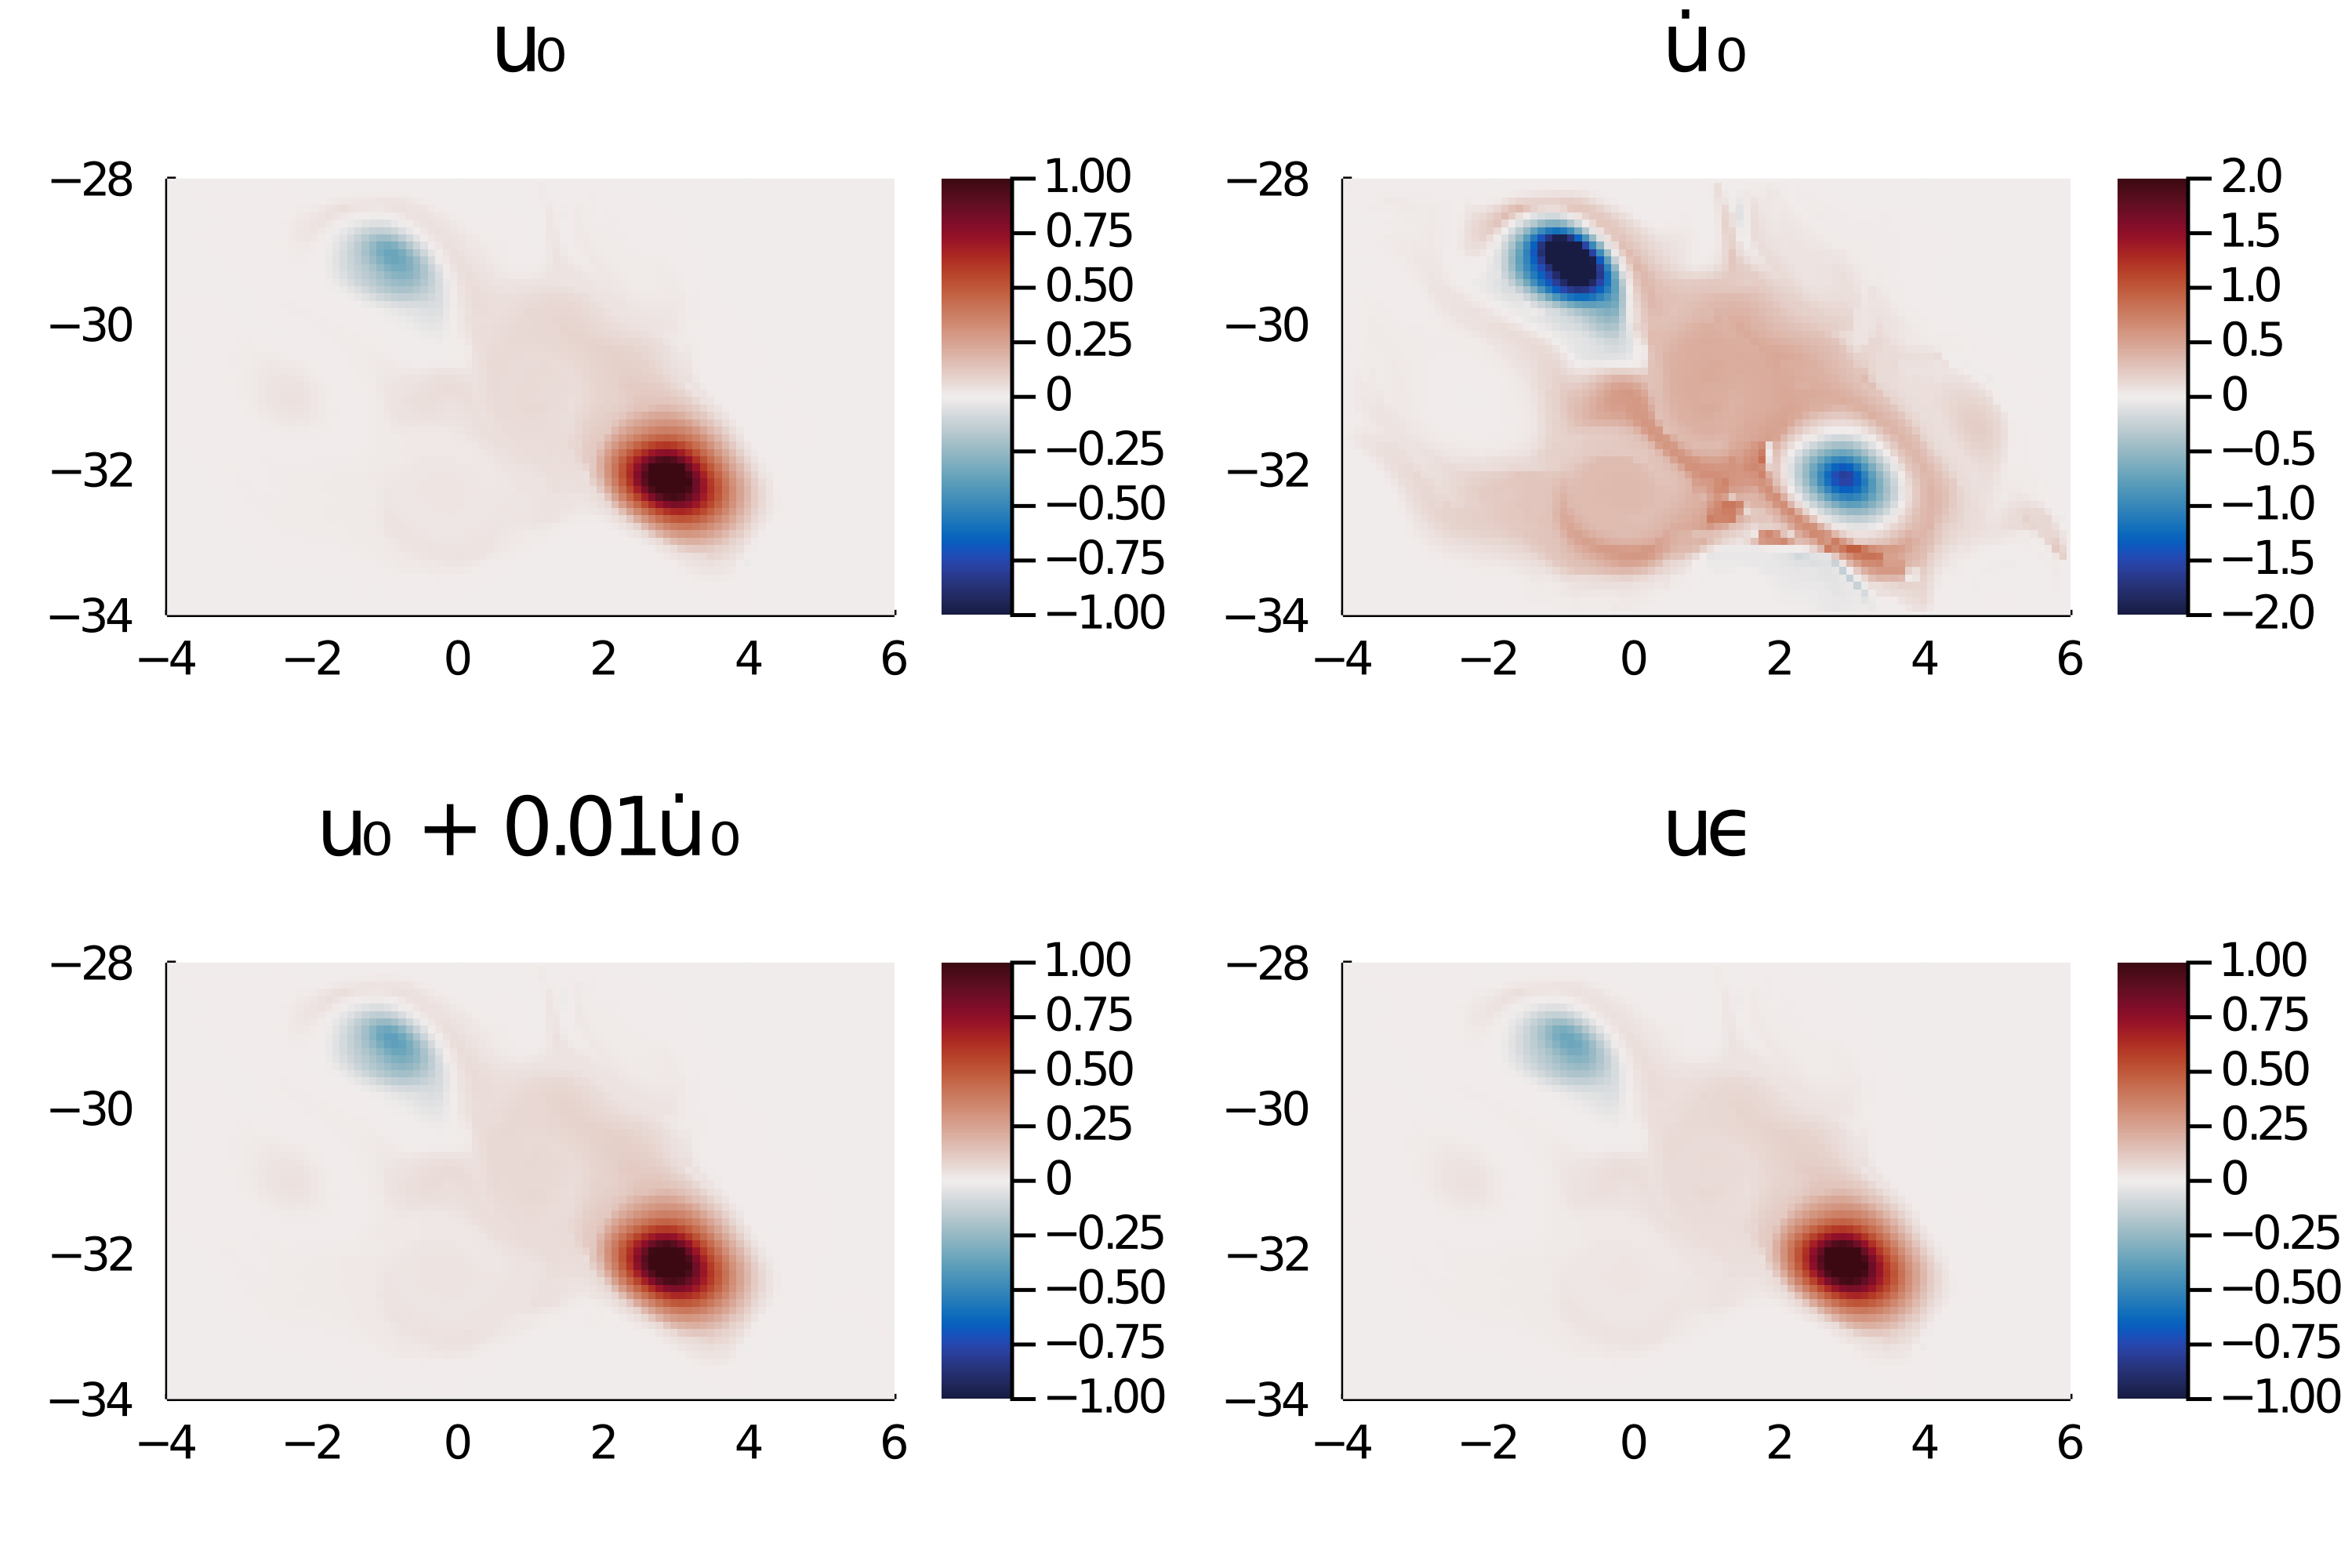

In [15]:
color =    :balance
xticks =   -4:2:6
yticks =   -34:2:-28
colorbar = :left
cmin =     -1
cmax =     1
cmin_lr =  -2
cmax_lr =  2
#unfortunately there is no option for colorbar ticks


original      = plot_u(ctx, u₀,           lon_resolution, lat_resolution, title="u₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
derivative    = plot_u(ctx, u_dot,       lon_resolution, lat_resolution, title="u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, lon_resolution, lat_resolution, title="u₀ + $(ϵ)u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
exact         = plot_u(ctx, uϵ,          lon_resolution, lat_resolution, title="uϵ", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(original,derivative,extrapolated,exact, fmt=:png, dpi=500)

In [16]:
# calculate the exact uminusϵ
DTminusϵ(x) = linearized_flow_autodiff(y -> T(y,-ϵ) , x)
Aminusϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTminusϵ(x))))
Kminusϵ = assembleStiffnessMatrix(ctx, Aminusϵ, bdata=bdata)
λminusϵ, uminusϵ = eigs(Kminusϵ, M, which=:SM)
@assert all(imag.(uminusϵ) .== 0)
@assert all(imag.(λminusϵ) .== 0)
uminusϵ = real.(uminusϵ[:,selected_ev])
λminusϵ = real.(λminusϵ[selected_ev])
uminusϵ = uminusϵ ./ sqrt(uminusϵ'*M*uminusϵ)
if uminusϵ[Int(floor(0.75*lat_resolution*lon_resolution+0.75*lon_resolution))]<0
    uminusϵ = -uminusϵ
end
λminusϵ

-20.00272437067021

In [17]:
λ₀ - ϵ*λ_dot 

-20.111110091661136

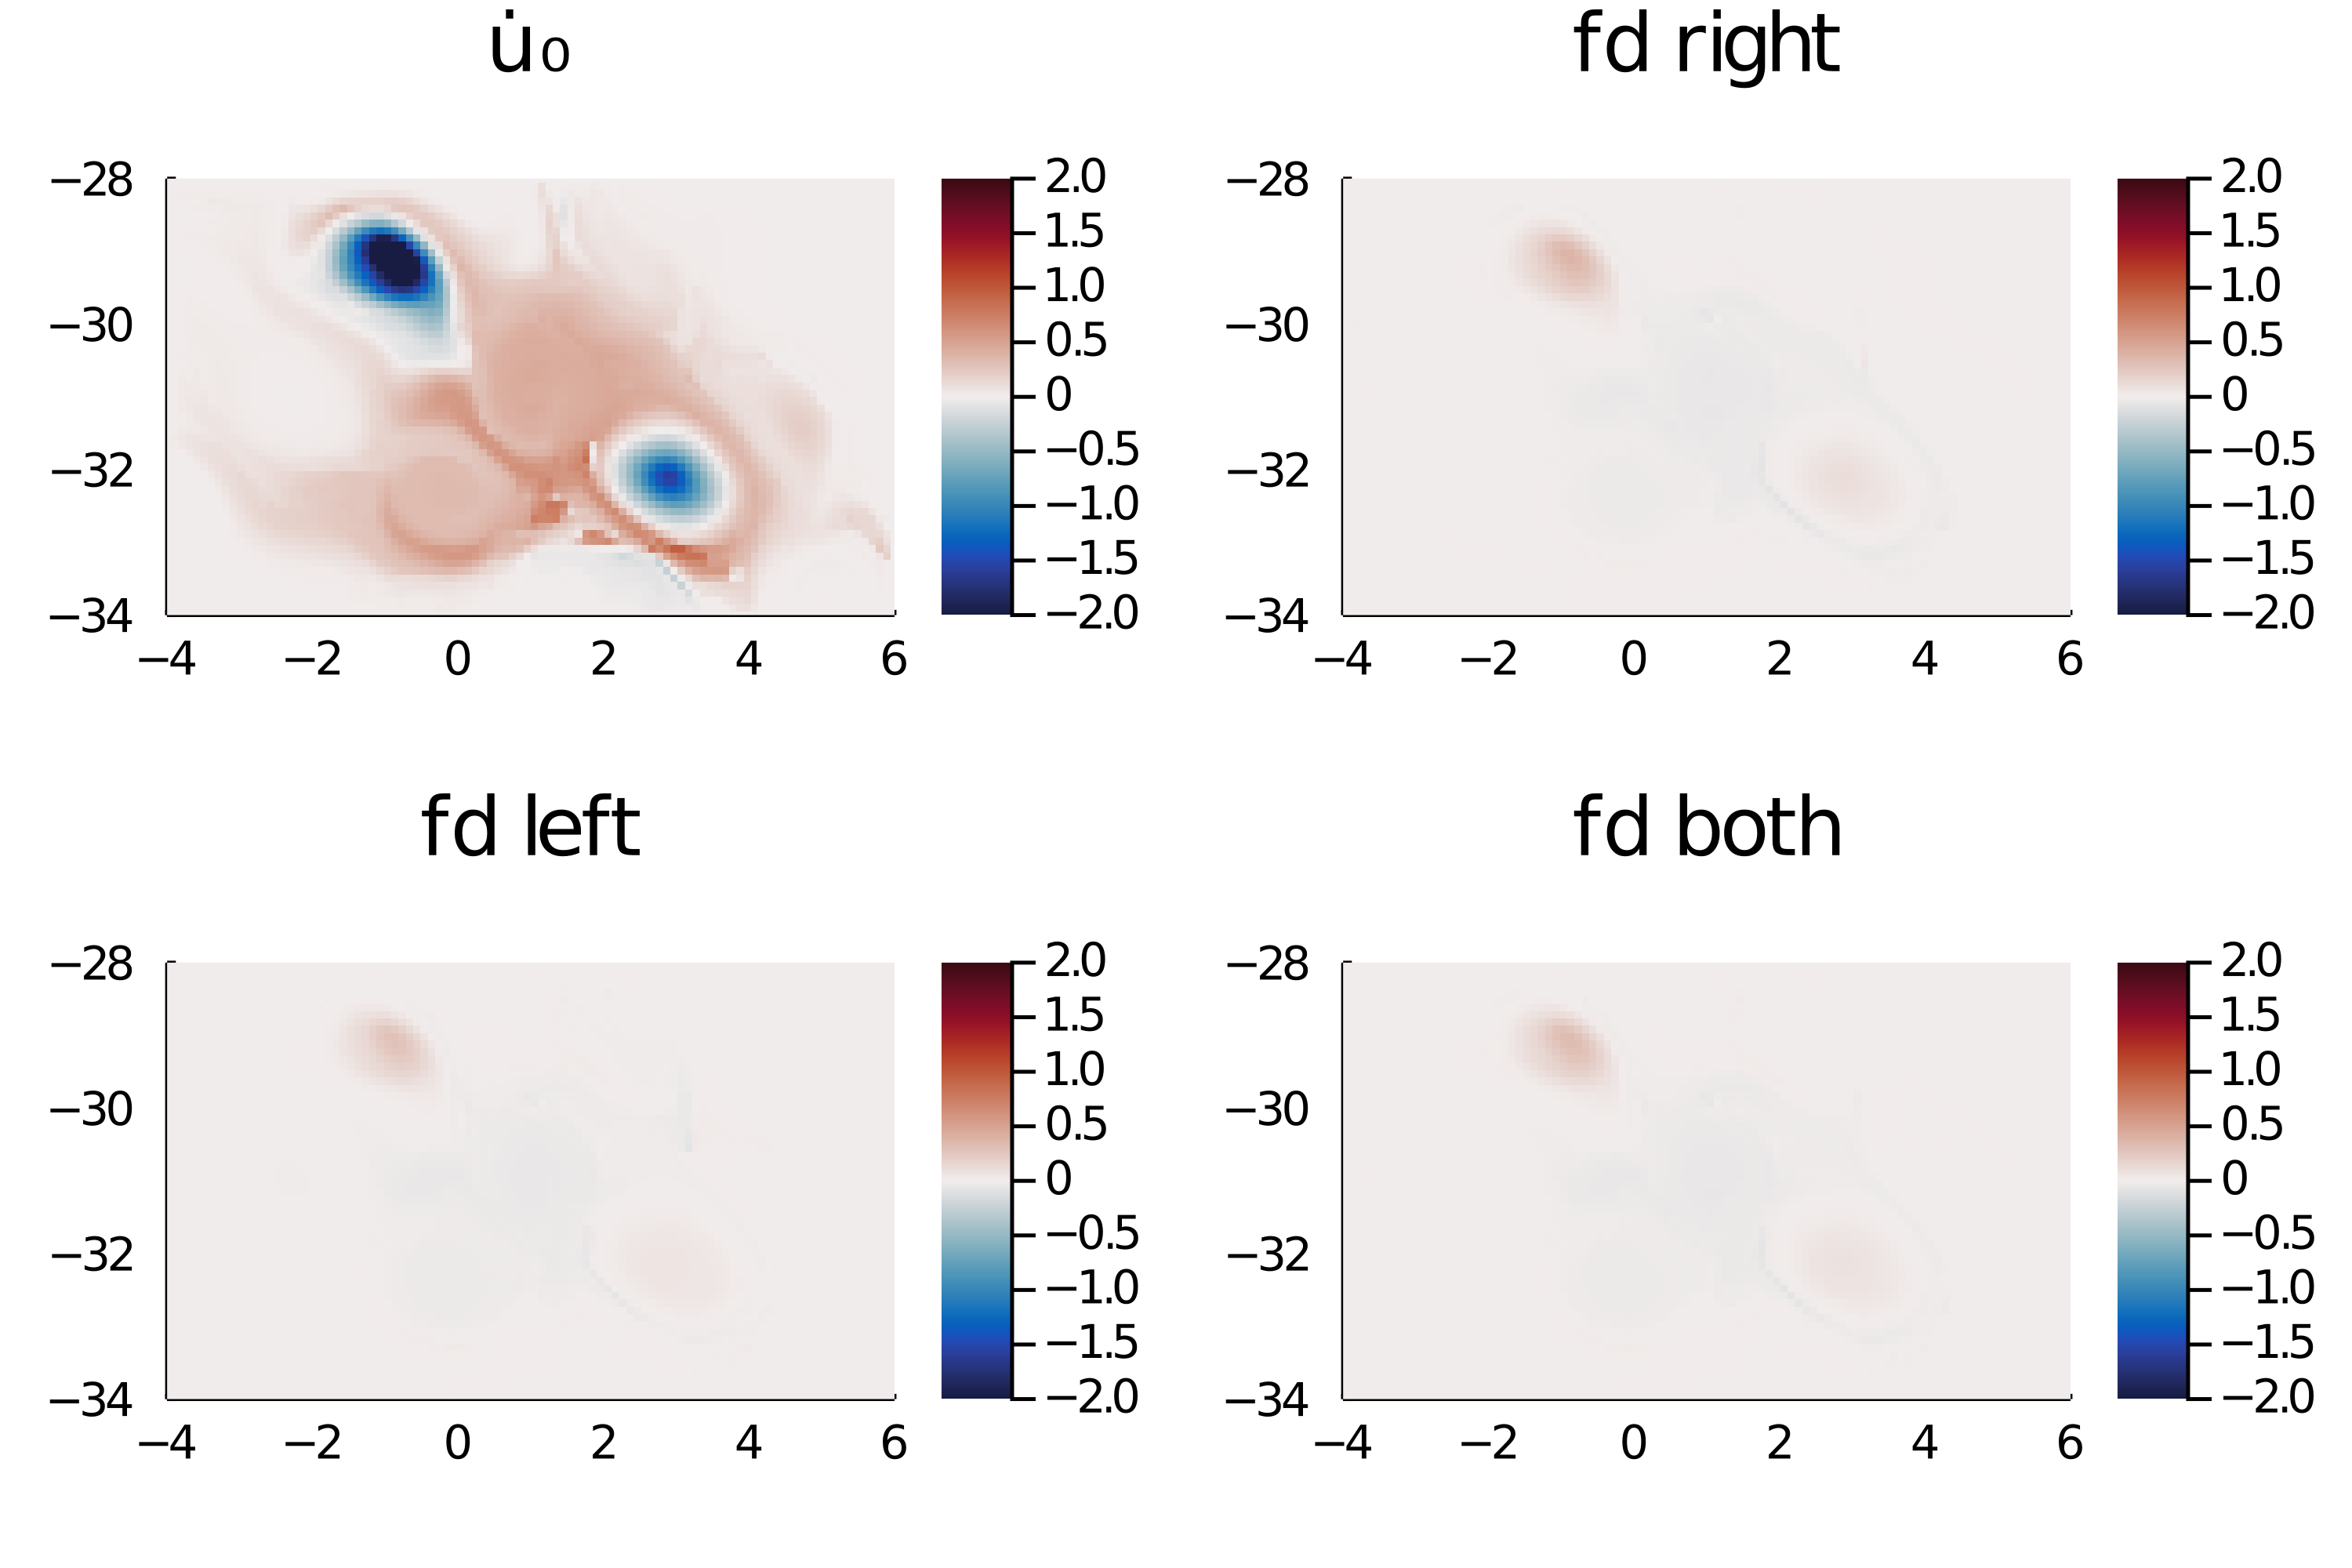

In [18]:
finite_diff_right = plot_u(ctx, (uϵ - u₀)/ϵ,          lon_resolution, lat_resolution, title="fd right", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
finite_diff_left = plot_u(ctx, (u₀ - uminusϵ)/ϵ,          lon_resolution, lat_resolution, title="fd left", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
finite_diff_both = plot_u(ctx, (uϵ - uminusϵ)/ 2ϵ,          lon_resolution, lat_resolution, title="fd both", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
Plots.plot(derivative,finite_diff_right,finite_diff_left,finite_diff_both, fmt=:png, dpi=500)